importing Jupyter notebook from rutgers_socreward.ipynb


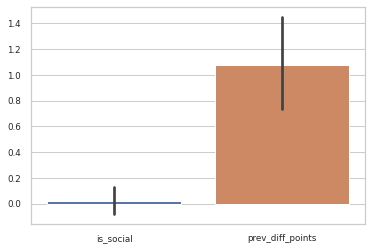

In [1]:
import pandas as pd
import numpy
import itertools
from utility import *
import import_ipynb
from rutgers_socreward import Subject, subject_list

In [2]:
#list of columns for making BIDS tsv file 
subset = ['deckchoice',
          'choice_onset',
          "press1_onset",
          "info_onset",
          "partner_onset",
          "press2_onset",
          'is_social', 
          'aff_feedback_prev_social', 
          'aff_feedback_prev_nonsocial',
          "aff_onset",
          "duration",
          'prev_diff_points',
          "RT1",
          "RT2", 
          'aff_feedback_curr',
          "lapse1",
          "lapse2"
]

#### Onset Type, Description : Duration

- choice_onset, Choose star or pentagon: RT1 or 3s 
- info_onset, Reveal choice value: 1.5s 
- partner-onset, Reveal Partner Choice: RT2 or 3s
- aff_onset,  Affective feedback win or lose: 1.5s

In [3]:
def generate_ev(sub, write = False):
    nan = 'n/a'
    for i in Subject(sub).matfiles:
        sub = sub
        run = Subject(sub).matfiles.index(i) + 1
        trial_dfs = []
        df = convert_mat(i)



        for index, row in df.iterrows():
            trial_df = pd.DataFrame()
            onset = []
            duration = []
            trial_type = []
            RT1 = []
            RT2 = []
            points = []


            if row.partner == 1:
                is_social = 'social'
            else:
                is_social = 'non_social'

            if row.deckchoice == 0:
                choice = 'choice_star'
            else:
                choice = 'choice_pentagon'

            if row.lapse1 == 1 or row.lapse2 == 1:
                lapse = '_lapse'
                dur_choice = dur_partner = 3
            else:
                lapse = ''
                dur_choice = row.RT1 
                dur_partner = row.RT2



            if row.deckchoice == 11 or row.deckchoice == 22:
                catch = '_catch'
                row.choice_onset = 'n/a'
                dur_choice = 'n/a'

            else:
                catch = ''


            #choice
            onset.append(row.choice_onset)
            duration.append(dur_choice)
            trial_type.append(f'partner-{is_social}_choice-{choice}{lapse}{catch}')
            RT1.append(row.RT1)
            RT2.append('n/a')
            points.append('n/a')

            
            #info
            onset.append(row.info_onset)
            duration.append(1.5)
            trial_type.append(f'partner-{is_social}_feedback-informative{lapse}{catch}')
            RT1.append('n/a')
            RT2.append('n/a')
            points.append(row.Npoints)


            #partner
            onset.append(row.partner_onset)
            duration.append(dur_partner)
            trial_type.append(f'partner-{is_social}_feedback-partner{lapse}{catch}')
            RT1.append('n/a')
            RT2.append(row.RT2)
            points.append('n/a')


            #aff
            onset.append(row.aff_onset)
            duration.append(1.5)
            trial_type.append(f'partner-{is_social}_feedback-affective{lapse}{catch}')
            RT1.append('n/a')
            RT2.append('n/a')
            points.append('n/a')


            trial_df['onset'] = onset
            trial_df['duration'] = duration
            trial_df['trial_type'] = trial_type
            trial_df['choice_RT'] = RT1
            trial_df['partner_RT'] = RT2
            trial_df['points'] = points


            trial_dfs.append(trial_df)

        bids_tsv = pd.concat(trial_dfs).reset_index()
        file_name = f'EVfiles/sub-{sub}_task-socreward_run-{run}_events.tsv'
        bids_tsv.to_csv(file_name, index = False)

    

In [4]:
for sub in subject_list:
    generate_ev(sub)

In [7]:
#fix index column

dfs = glob.glob('EVfiles/*.tsv')

for i in dfs:
    df = pd.read_csv(i, index_col=False)
    df['trialn'] = range(1, len(df) + 1)
    df = df.iloc[:, 1:]
    df.to_csv(i, index = False)
    
    
    
    